In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)
batch_size = 8
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


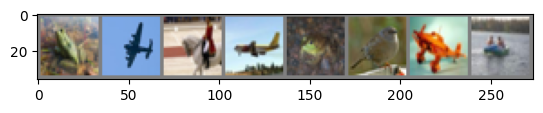

frog  plane horse plane frog  bird  plane ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
def im_show(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
im_show(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

#training the network
for epoch in range(10):
    running_loss = 0.0
    for i, data, in enumerate(trainloader, 0):
        #get the inputs;; data is alist of [inputs, labels]
        inputs, labels = data
        #zero the parameters gradients
        optimizer.zero_grad()

        #forward, backward, optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print the stats
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'{epoch+1}, {i + 1: 5d} loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print("finished training")
        

1,  2000 loss: 2.303
1,  4000 loss: 2.300
1,  6000 loss: 2.297
2,  2000 loss: 2.284
2,  4000 loss: 2.247
2,  6000 loss: 2.140
3,  2000 loss: 1.999
3,  4000 loss: 1.931
3,  6000 loss: 1.879
4,  2000 loss: 1.819
4,  4000 loss: 1.755
4,  6000 loss: 1.713
5,  2000 loss: 1.661
5,  4000 loss: 1.634
5,  6000 loss: 1.606
6,  2000 loss: 1.571
6,  4000 loss: 1.549
6,  6000 loss: 1.540
7,  2000 loss: 1.514
7,  4000 loss: 1.500
7,  6000 loss: 1.464
8,  2000 loss: 1.456
8,  4000 loss: 1.458
8,  6000 loss: 1.434
9,  2000 loss: 1.423
9,  4000 loss: 1.397
9,  6000 loss: 1.401
10,  2000 loss: 1.380
10,  4000 loss: 1.364
10,  6000 loss: 1.369
finished training


In [6]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

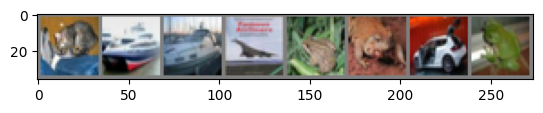

GroundTruth:  cat   ship  ship  plane


In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

#print images
im_show(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


In [10]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 55.8 %
Accuracy for class: car   is 67.7 %
Accuracy for class: bird  is 46.1 %
Accuracy for class: cat   is 28.3 %
Accuracy for class: deer  is 31.0 %
Accuracy for class: dog   is 50.0 %
Accuracy for class: frog  is 57.2 %
Accuracy for class: horse is 62.9 %
Accuracy for class: ship  is 61.4 %
Accuracy for class: truck is 53.1 %
